In [1]:
## This notebook is for comparing the Transmitter off and RFI measurements...
import os
workingdir='/home/tyndall/newburghlab-drone'
os.chdir(workingdir)

from dronehacks.GBO_Corr_Class import *
from dronehacks.Drone_Class import *
from dronehacks.CONCAT_Class import *

In [2]:
## Specify choice of origin in llh: (Southeast Corner of LFOP courtyard, by Dome)
LFOP_SECorner_Vect=pygeodesy.ellipsoidalNvector.LatLon(41.32094627710947, -72.92185799298781, 23.964228339399998).to3llh()

In [3]:
## RECEIVER INFORMATION is needed to initialize the geometric environments: ##

## Must include some 'key' strings for labelling/identifying receivers:
Array_Keys=['Cart']
## Must Specify Coordinates and Pointings of receivers in Local Cartesian in an array of shape: n_receivers x 3 ##
Array_Coords=np.array([[2.0,-5.0,0.1]])
## If pointings are defined by vectors in Local Coordinates (E,N,U) use:
Array_Pointings=np.array([[0,0,1]]) # +Z (up) in LC 
## If pointings are defined by angles from zenith, use:
Array_Pointings=np.array([RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0])])
## Define Array Polarizations (2 per dish) in Local Cartesian E,N,U:
Array_Pols=np.array([[[1,0,0],[0,1,0]]]) # E,N \

In [4]:
## Flight 1: FF EW-pol Pulsed 50m Source GRID FILES:
gaindir='/hirax/LFOP_Data/20211012T181246Z_Suit_digitalgain/'
datadir='/hirax/LFOP_Data/20211012T181246Z_Suit/corr/20211012T181305Z/'

FF_Grid_1_corr=Corr_Data(n_channels=2,\
                         chmap=[0,1],\
                         Data_Directory=datadir,\
                         Gain_Directory=gaindir,\
                         Working_Directory=workingdir)

Initializing Correlator Class using:
 --> /hirax/LFOP_Data/20211012T181246Z_Suit/corr/20211012T181305Z/
 --> Arrays initialized with shape (389, 64, 1023, 2)
Assigning array values by reading in data files:
 --> Loading File: 0388/0388

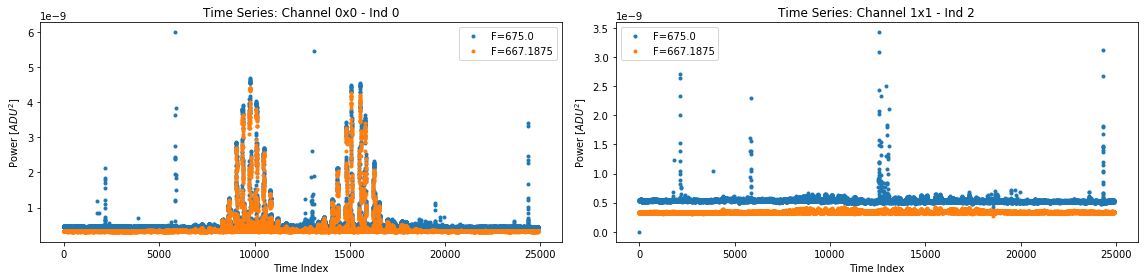

In [5]:
FF_Grid_1_corr.Plot_Auto_Corr_Time_Series(freqlist=[320,340])

In [6]:
## Read Drone Data: 
drone_directory='/hirax/all_drone_data/datcon_csv/'
ndishes=1
FF_Grid_1_drone=Drone_Data(dronedir=drone_directory,\
                                FLYTAG='FLY555.csv',\
                                Origin_llh=LFOP_SECorner_Vect,\
                                Origin_key='LFOP_SE_Corner',\
                                dkeys=Array_Keys[:ndishes],\
                                dcoords=Array_Coords[:ndishes],\
                                dpointings=Array_Pointings[:ndishes],\
                                dpols=Array_Pols[:ndishes])

Initializing drone data via datcon_csv routine: FLY555.csv
 --> Skipping rows 1 to 499 to eliminate NAN values
Timestamp interpolation succeeded
 --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
 --> generating dish and receiver line of sight coordinates.


plotting drone coordinates for all time samples:


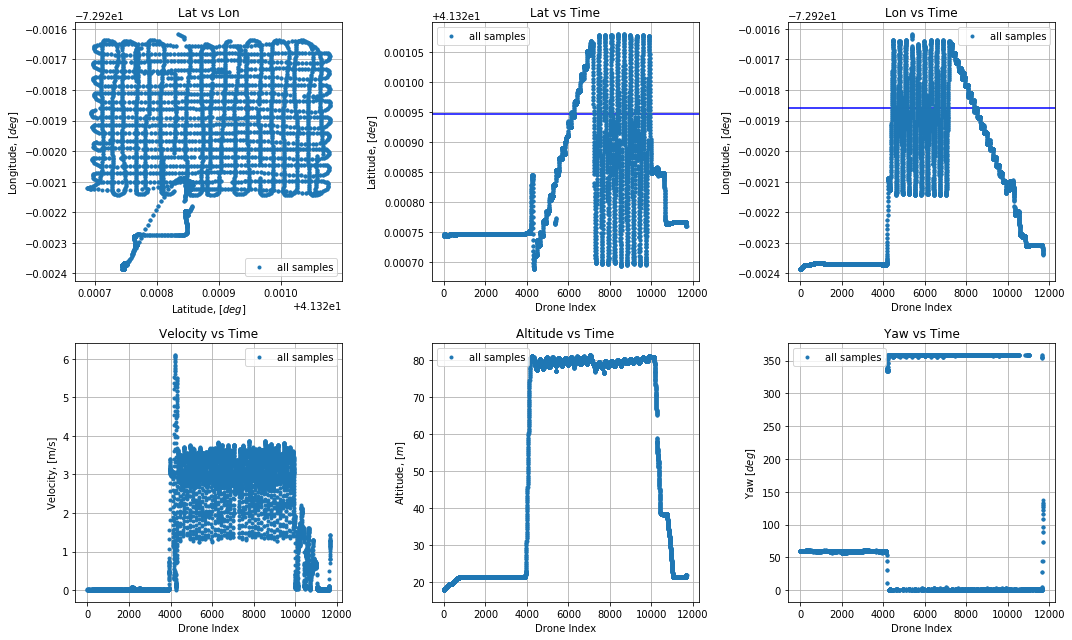

In [7]:
FF_Grid_1_drone.Plot_Drone_Coordinates()

In [138]:
## Initialize CONCAT class and interpolate drone coords:
FF_Grid_1_Concat=CONCAT(CORRDATCLASS=FF_Grid_1_corr,DRONEDATCLASS=FF_Grid_1_drone,instrument_name="LFOP Dish")

Initializing CONCAT CLASS using:
 --> /hirax/LFOP_Data/20211012T181246Z_Suit/corr/20211012T181305Z/
 --> FLY555.csv
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 22859 elements
  --> drone timestamp axis contains 11688 elements


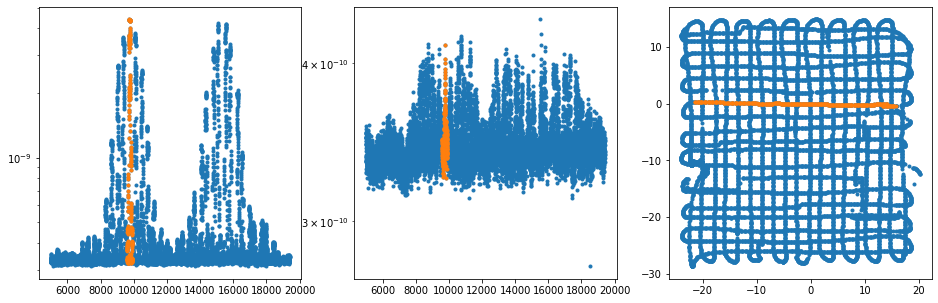

In [139]:
fig1,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
tlb,tub=[0,-1]
tlb,tub=[5000,19400]
ax1.semilogy(FF_Grid_1_Concat.t_index[tlb:tub],FF_Grid_1_Concat.V[tlb:tub,340,0],'.')
ax2.semilogy(FF_Grid_1_Concat.t_index[tlb:tub],FF_Grid_1_Concat.V[tlb:tub,340,1],'.')
ax3.plot(FF_Grid_1_Concat.drone_xyz_LC_interp[tlb:tub,0],FF_Grid_1_Concat.drone_xyz_LC_interp[tlb:tub,1],'.')
tlb,tub=[9600,9900]
ax1.semilogy(FF_Grid_1_Concat.t_index[tlb:tub],FF_Grid_1_Concat.V[tlb:tub,340,0],'.')
ax2.semilogy(FF_Grid_1_Concat.t_index[tlb:tub],FF_Grid_1_Concat.V[tlb:tub,340,1],'.')
ax3.plot(FF_Grid_1_Concat.drone_xyz_LC_interp[tlb:tub,0],FF_Grid_1_Concat.drone_xyz_LC_interp[tlb:tub,1],'.')

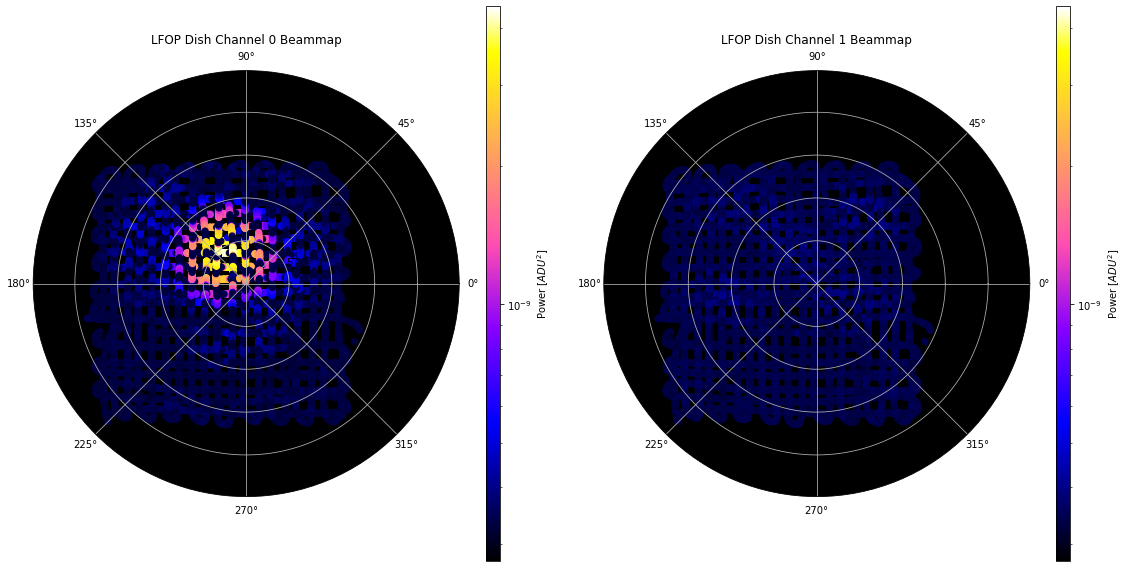

In [140]:
FF_Grid_1_Concat.Plot_Beammap_LC(t_bounds=[5000,19400],\
                                 f_bounds=[339,340],\
                                 coord_args="Pol", #"LC","Pol"\
                                 pulse_args=None,# None,"on","off","meanspec_on","meanspec_bg","meanspec_meansub"\
                                 cbounds=[],#[1e-11,1e-7],\
                                 dotsize=40)

Maximum Pearson_R Correlations:
  --> t_indices = [582. 564.]
  --> t_offsets = [-0.41741742 -0.43543544]
Selecting global time offset:
  --> global_t_offset = -0.4054264264
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


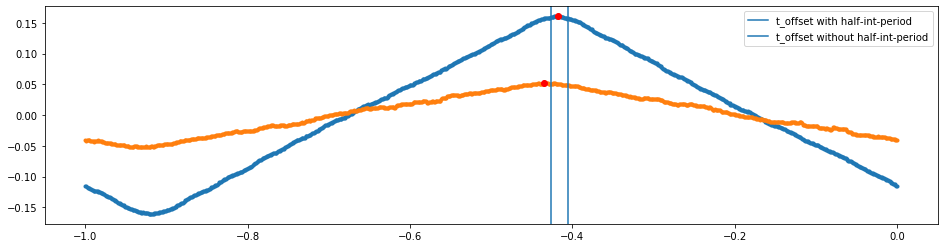

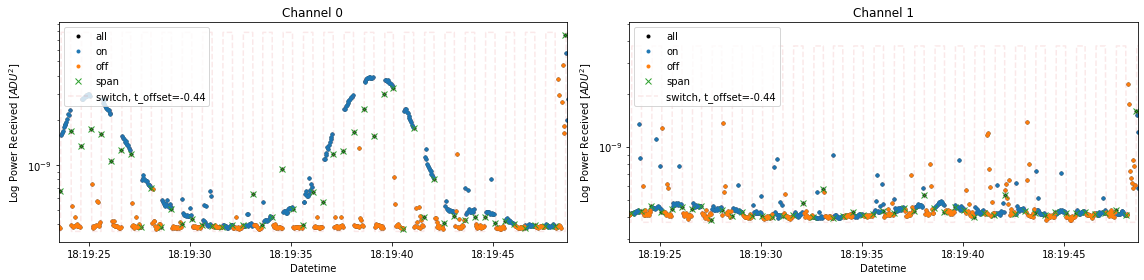

In [141]:
## Find the pulsed source signal: (comment out if source was broadcast continuously)
FF_Grid_1_Concat.Extract_Source_Pulses(Period=1.0e6,\
                                       Dutycycle=0.5e6,\
                                       t_bounds=[9000,9600],\
                                       f_ind=[330],\
                                       half_int_period=+0.021)

In [142]:
FF_Grid_1_Concat.Perform_Background_Subtraction()

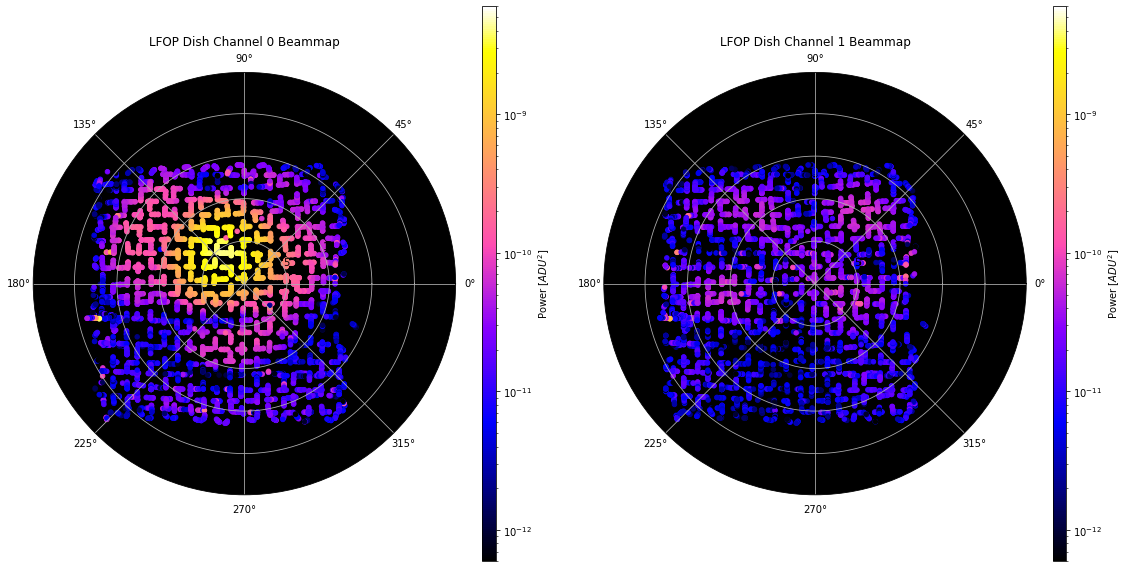

In [144]:
FF_Grid_1_Concat.Plot_Beammap_LC(t_bounds=[5000,19400],\
                                 f_bounds=[330,340],\
                                 coord_args="Pol", #"LC","Pol"\
                                 pulse_args="bgsub",# None,"on","off","bg","bgsub"\
                                 cbounds=[6e-13,6e-9],#[]\
                                 dotsize=20)

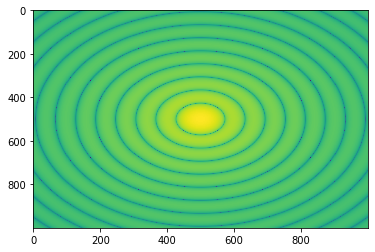

In [145]:
def Airy_2d_LC_opt(P,x,y,V):
    amp,x0,y0,rad=P
    return AD.evaluate(x,y,amp,x0,y0,rad)-V

def Gauss_2d_LC_opt(P,x,y,V):
    amp,x0,xsig,y0,ysig=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))-V

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))

from astropy.modeling.models import AiryDisk2D

AD=AiryDisk2D(1,5,5,radius=1)
x=np.linspace(-60,60,1000)
y=np.linspace(-60,60,1000)
dat=np.zeros((len(x),len(y)))
for i,val in enumerate(x):
    dat[i]=AD.evaluate(val,y,10,0,0,radius=8.75)
    
imshow(dat,aspect="auto",norm=LogNorm())

In [146]:
tlb,tub=[5000,19500] # Full Grid
t_inds=np.intersect1d(FF_Grid_1_Concat.inds_on,FF_Grid_1_Concat.t_index[tlb:tub])
fcutarr=np.arange(256,384)
AFit_f_params=np.zeros((FF_Grid_1_Concat.n_channels,len(fcutarr),4))
GFit_f_params=np.zeros((FF_Grid_1_Concat.n_channels,len(fcutarr),5))
AFit_f_params_B=np.zeros((FF_Grid_1_Concat.n_channels,len(fcutarr),4))
GFit_f_params_B=np.zeros((FF_Grid_1_Concat.n_channels,len(fcutarr),5))
for k in range(FF_Grid_1_Concat.n_channels):
    print(k)
    for j,find in enumerate(fcutarr):
        mbx=FF_Grid_1_Concat.drone_xyz_LC_interp[t_inds,0]
        mby=FF_Grid_1_Concat.drone_xyz_LC_interp[t_inds,1]
        mbz=FF_Grid_1_Concat.drone_xyz_LC_interp[t_inds,2]
        mbV=FF_Grid_1_Concat.V_bgsub[t_inds,find,k]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        x00=Array_Coords[int(k/2),0]
        y00=Array_Coords[int(k/2),1]
        ## airy params:
        rad0=5.0
        ## 2dgauss params:
        xsig0=20.0
        ysig0=20.0
        pA=np.array([amp0,x00,y00,rad0])
        BA=(np.array([0.0,-10.0,-10.0,0.0]),np.array([1e-5,10.0,10.0,100.0]))
        pG=np.array([amp0,x00,xsig0,y00,ysig0])
        BG=(np.array([0.0,-10.0,0.0,-10.0,0.0]),np.array([1e-5,10.0,100.0,10.0,100.0]))
        AFit_f_params[k,j,:]=least_squares(Airy_2d_LC_opt,x0=pA,args=mb_input_data).x
        GFit_f_params[k,j,:]=least_squares(Gauss_2d_LC_opt,x0=pG,args=mb_input_data).x
        AFit_f_params_B[k,j,:]=least_squares(Airy_2d_LC_opt,x0=pA,bounds=BA,args=mb_input_data,method='dogbox').x
        GFit_f_params_B[k,j,:]=least_squares(Gauss_2d_LC_opt,x0=pG,bounds=BG,args=mb_input_data,method='dogbox').x

0


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


1


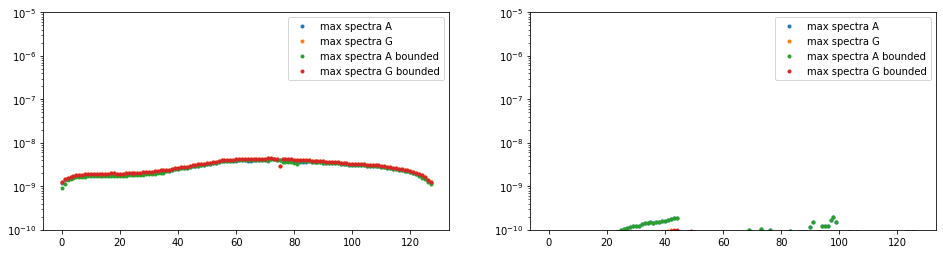

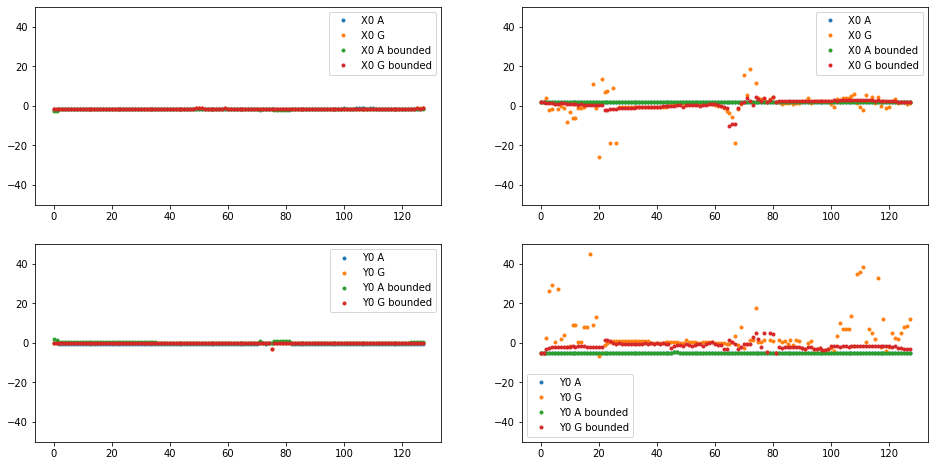

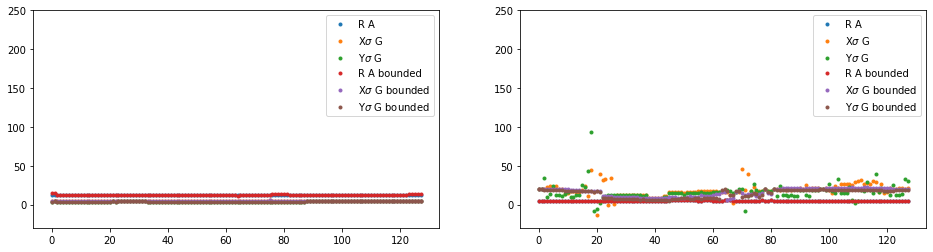

In [147]:
fig1,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,4))
for z,ax in enumerate([ax1,ax2]):
    ax.semilogy(AFit_f_params[z,:,0],'.',label="max spectra A")
    ax.semilogy(GFit_f_params[z,:,0],'.',label="max spectra G")
    ax.semilogy(AFit_f_params_B[z,:,0],'.',label="max spectra A bounded")
    ax.semilogy(GFit_f_params_B[z,:,0],'.',label="max spectra G bounded")
    ax.legend()
    ax.set_ylim(1e-10,1e-5)
    
fig2,[[ax1,ax2],[ax3,ax4]]=subplots(nrows=2,ncols=2,figsize=(16,8))
for z,ax in enumerate([ax1,ax2]):
    ax.plot(AFit_f_params[z,:,1],'.',label="X0 A")
    ax.plot(GFit_f_params[z,:,1],'.',label="X0 G")
    ax.plot(AFit_f_params_B[z,:,1],'.',label="X0 A bounded")
    ax.plot(GFit_f_params_B[z,:,1],'.',label="X0 G bounded")
    ax.legend()
    ax.set_ylim(-50,50)
for z,ax in enumerate([ax3,ax4]):
    ax.plot(AFit_f_params[z,:,2],'.',label="Y0 A")
    ax.plot(GFit_f_params[z,:,3],'.',label="Y0 G")
    ax.plot(AFit_f_params_B[z,:,2],'.',label="Y0 A bounded")
    ax.plot(GFit_f_params_B[z,:,3],'.',label="Y0 G bounded")
    ax.legend()
    ax.set_ylim(-50,50)
    
fig3,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,4))
for z,ax in enumerate([ax1,ax2]):
    ax.plot(AFit_f_params[z,:,3],'.',label="R A")
    ax.plot(GFit_f_params[z,:,2],'.',label="X$\sigma$ G")
    ax.plot(GFit_f_params[z,:,4],'.',label="Y$\sigma$ G")
    ax.plot(AFit_f_params_B[z,:,3],'.',label="R A bounded")
    ax.plot(GFit_f_params_B[z,:,2],'.',label="X$\sigma$ G bounded")
    ax.plot(GFit_f_params_B[z,:,4],'.',label="Y$\sigma$ G bounded")
    ax.legend()
    ax.set_ylim(-30,250)

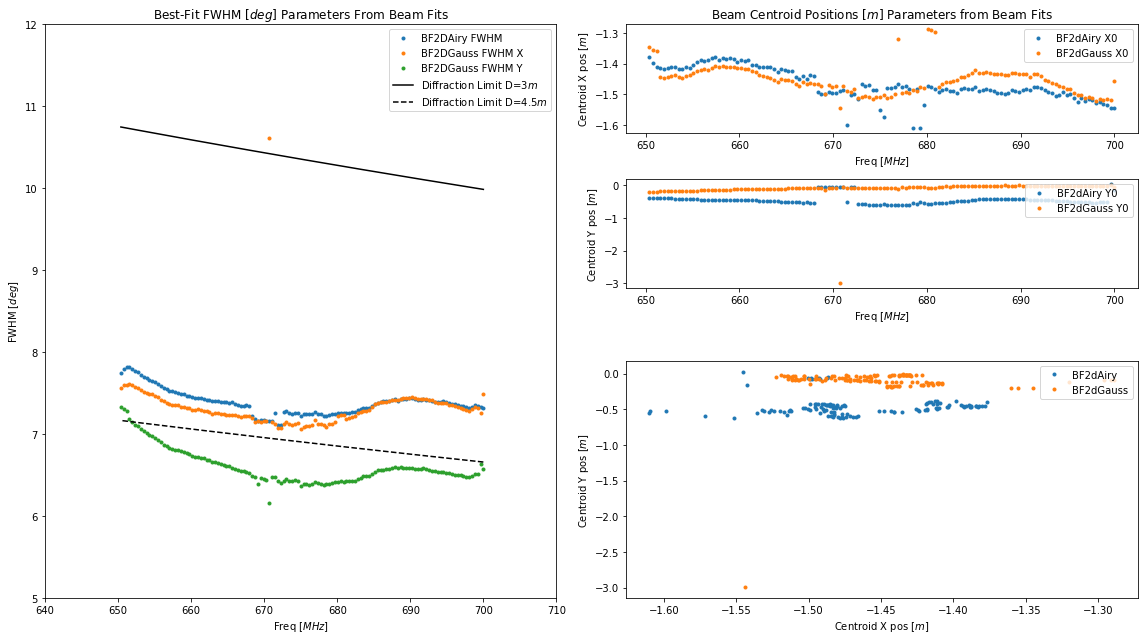

In [148]:
## Use the returned fit parameters to plot FWHM and centroid for these fits:
    # Airy Fit Parameter array:  pA=np.array([amp0,x00,y00,rad0])
    # Gauss Fit Parameter array: pG=np.array([amp0,x00,xsig0,y00,ysig0])

## FWHM in meters (x,y) and degrees in FoV:
Afwhmm_f=2*1.616/3.832*AFit_f_params[:,:,3]
Afwhmd_f=2*180.0/np.pi*np.arctan(1.616/3.832*AFit_f_params[:,:,3]/np.nanmean(mbz))
Gfwhmxm_f=2.355*GFit_f_params[:,:,2]
Gfwhmxd_f=2*180.0/np.pi*np.arctan(0.5*2.355*GFit_f_params[:,:,2]/np.nanmean(mbz))
Gfwhmym_f=2.355*GFit_f_params[:,:,4]
Gfwhmyd_f=2*180.0/np.pi*np.arctan(0.5*2.355*GFit_f_params[:,:,4]/np.nanmean(mbz))

## Centroid Location in meters (x,y) and degrees:
ACent_f=AFit_f_params[:,:,[1,2]]
ACentd_f=np.arctan(AFit_f_params[:,:,[1,2]]/np.nanmean(mbz))
GCent_f=GFit_f_params[:,:,[1,3]]
GCentd_f=np.arctan(GFit_f_params[:,:,[1,3]]/np.nanmean(mbz))

wavelength_m=(3.0*(10.0**8.0))/(FF_Grid_1_Concat.f_arr[fcutarr]*1.0e6)
difflimit=180.0/np.pi*1.22*wavelength_m
   
g=0    
    
fig1=figure(figsize=(16,9))
ax1=fig1.add_subplot(1,2,1)
ax1.plot(FF_Grid_1_Concat.f_arr[fcutarr],Afwhmd_f[g],'.',label="BF2DAiry FWHM")
ax1.plot(FF_Grid_1_Concat.f_arr[fcutarr],Gfwhmxd_f[g],'.',label="BF2DGauss FWHM X")
ax1.plot(FF_Grid_1_Concat.f_arr[fcutarr],Gfwhmyd_f[g],'.',label="BF2DGauss FWHM Y")
ax1.plot(FF_Grid_1_Concat.f_arr[fcutarr],difflimit/3.0,'k-',markersize=0.5,label="Diffraction Limit D=3$m$")
ax1.plot(FF_Grid_1_Concat.f_arr[fcutarr],difflimit/4.5,'k--',markersize=0.5,label="Diffraction Limit D=4.5$m$")
ax1.legend(loc=1)
ax1.set_ylabel("FWHM [$deg$]")
ax1.set_xlabel("Freq [$MHz$]")
ax1.set_title("Best-Fit FWHM [$deg$] Parameters From Beam Fits")


ax2=fig1.add_subplot(4,2,2)
ax2.plot(FF_Grid_1_Concat.f_arr[fcutarr],ACent_f[g,:,0],'.',label='BF2dAiry X0')
ax2.plot(FF_Grid_1_Concat.f_arr[fcutarr],GCent_f[g,:,0],'.',label='BF2dGauss X0')
ax2.set_ylabel("Centroid X pos [$m$]")
ax2.set_xlabel("Freq [$MHz$]")
ax2.set_title("Beam Centroid Positions [$m$] Parameters from Beam Fits")
ax2.legend(loc=1)

ax3=fig1.add_subplot(4,2,4)
ax3.plot(FF_Grid_1_Concat.f_arr[fcutarr],ACent_f[g,:,1],'.',label='BF2dAiry Y0')
ax3.plot(FF_Grid_1_Concat.f_arr[fcutarr],GCent_f[g,:,1],'.',label='BF2dGauss Y0')
ax3.set_ylabel("Centroid Y pos [$m$]")
ax3.set_xlabel("Freq [$MHz$]")
ax3.legend(loc=1)

ax4=fig1.add_subplot(2,2,4)
ax4.plot(ACent_f[g,:,0],ACent_f[g,:,1],'.',label='BF2dAiry')
ax4.plot(GCent_f[g,:,0],GCent_f[g,:,1],'.',label='BF2dGauss')
ax4.set_xlabel("Centroid X pos [$m$]")
ax4.set_ylabel("Centroid Y pos [$m$]")
ax4.legend(loc=1)

ax1.set_xlim(640,710)
ax1.set_ylim(5,12)
#ax4.set_xlim(-1.8,-1.2)
#ax4.set_ylim(-0.5,0.5)
tight_layout()



In [22]:
## Flight 1: FF EW-pol Pulsed 50m Source GRID FILES:
gaindir='/hirax/LFOP_Data/20211013T170944Z_Suit_digitalgain/'
datadir='/hirax/LFOP_Data/20211013T170944Z_Suit/corr/20211013T171003Z/'

NF_Grid_1_corr=Corr_Data(n_channels=2,\
                         chmap=[0,1],\
                         Data_Directory=datadir,\
                         Gain_Directory=gaindir,\
                         Working_Directory=workingdir)

Initializing Correlator Class using:
 --> /hirax/LFOP_Data/20211013T170944Z_Suit/corr/20211013T171003Z/
 --> Arrays initialized with shape (132, 64, 1023, 2)
Assigning array values by reading in data files:
 --> Loading File: 0131/0131

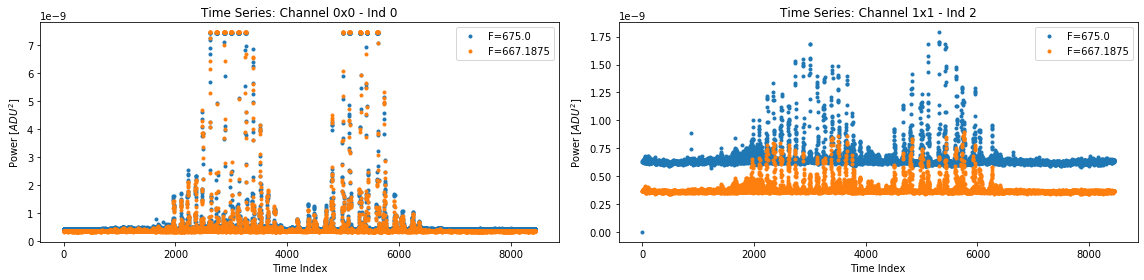

In [23]:
NF_Grid_1_corr.Plot_Auto_Corr_Time_Series(freqlist=[320,340])

In [28]:
## Read Drone Data: 
drone_directory='/hirax/all_drone_data/datcon_csv/'
ndishes=1
NF_Grid_1_drone=Drone_Data(dronedir=drone_directory,\
                                FLYTAG='FLY566.csv',\
                                Origin_llh=LFOP_SECorner_Vect,\
                                Origin_key='LFOP_SE_Corner',\
                                dkeys=Array_Keys[:ndishes],\
                                dcoords=Array_Coords[:ndishes],\
                                dpointings=Array_Pointings[:ndishes],\
                                dpols=Array_Pols[:ndishes])

Initializing drone data via datcon_csv routine: FLY566.csv
 --> Skipping rows 1 to 499 to eliminate NAN values
Timestamp interpolation succeeded
 --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
 --> generating dish and receiver line of sight coordinates.


plotting drone coordinates for all time samples:


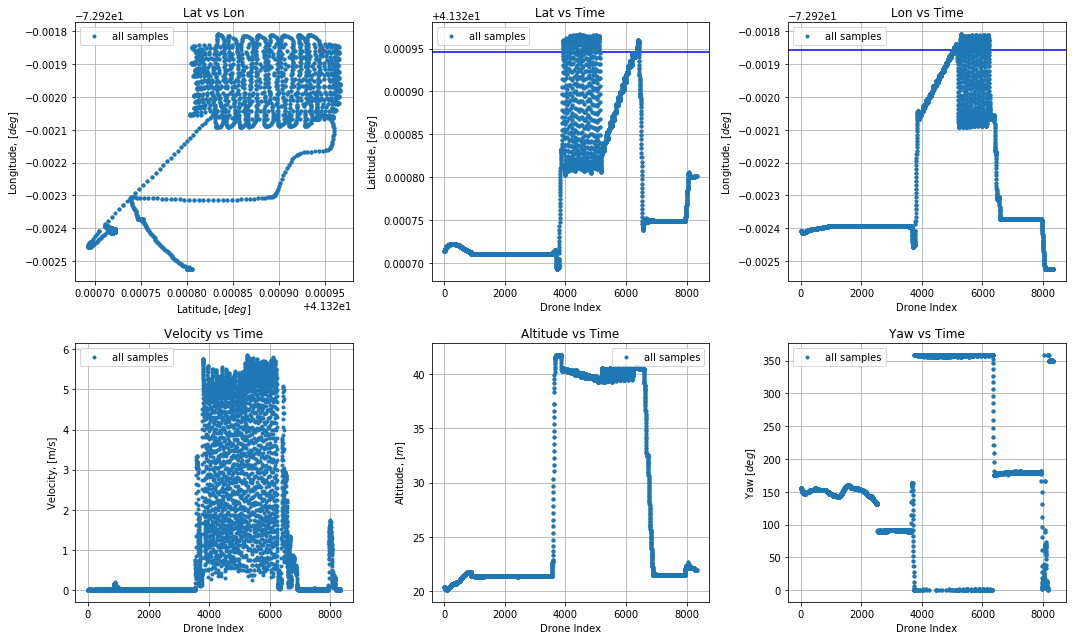

In [29]:
NF_Grid_1_drone.Plot_Drone_Coordinates()

In [30]:
## Initialize CONCAT class and interpolate drone coords:
NF_Grid_1_Concat=CONCAT(CORRDATCLASS=NF_Grid_1_corr,DRONEDATCLASS=NF_Grid_1_drone,instrument_name="LFOP Dish")

Initializing CONCAT CLASS using:
 --> /hirax/LFOP_Data/20211013T170944Z_Suit/corr/20211013T171003Z/
 --> FLY566.csv
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 8448 elements
  --> drone timestamp axis contains 8329 elements


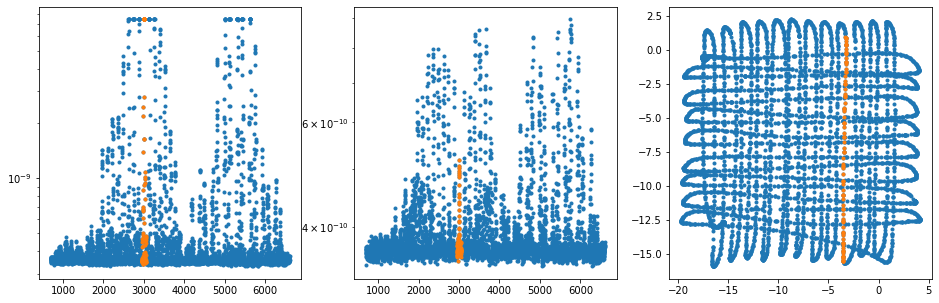

In [92]:
fig1,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
tlb,tub=[0,-1]
tlb,tub=[700,6600]
ax1.semilogy(NF_Grid_1_Concat.t_index[tlb:tub],NF_Grid_1_Concat.V[tlb:tub,340,0],'.')
ax2.semilogy(NF_Grid_1_Concat.t_index[tlb:tub],NF_Grid_1_Concat.V[tlb:tub,340,1],'.')
ax3.plot(NF_Grid_1_Concat.drone_xyz_LC_interp[tlb:tub,0],NF_Grid_1_Concat.drone_xyz_LC_interp[tlb:tub,1],'.')
tlb,tub=[2950,3050]
ax1.semilogy(NF_Grid_1_Concat.t_index[tlb:tub],NF_Grid_1_Concat.V[tlb:tub,340,0],'.')
ax2.semilogy(NF_Grid_1_Concat.t_index[tlb:tub],NF_Grid_1_Concat.V[tlb:tub,340,1],'.')
ax3.plot(NF_Grid_1_Concat.drone_xyz_LC_interp[tlb:tub,0],NF_Grid_1_Concat.drone_xyz_LC_interp[tlb:tub,1],'.')

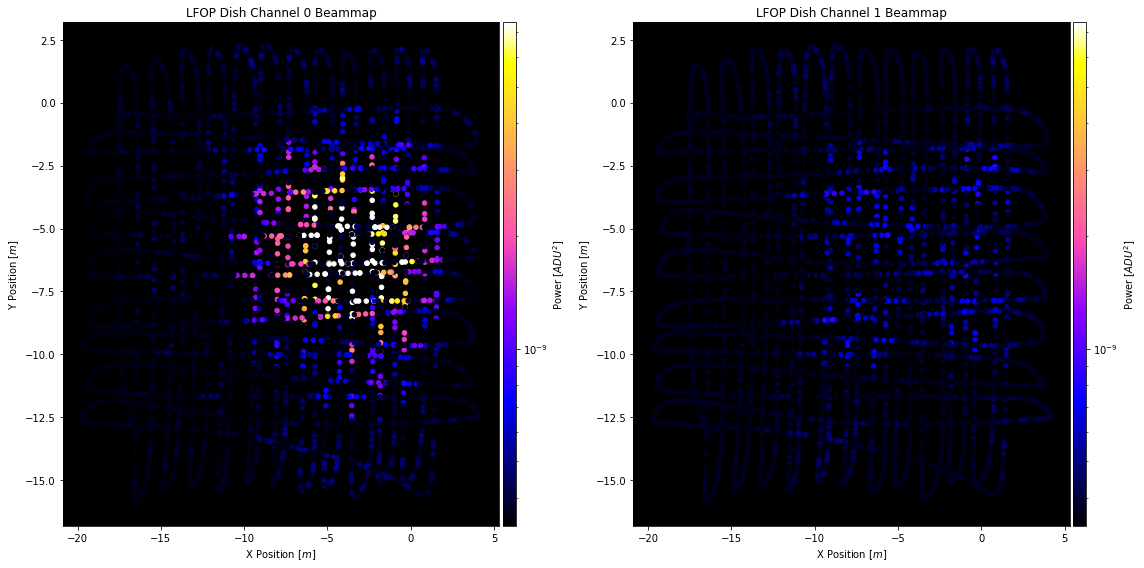

In [108]:
NF_Grid_1_Concat.Plot_Beammap_LC(t_bounds=[700,6600],\
                                 f_bounds=[339,340],\
                                 coord_args="LC", #"LC","Pol"\
                                 pulse_args=None,# None,"on","off","bg","bgsub"\
                                 cbounds=[],#[1e-11,1e-7],\
                                 dotsize=20)

Maximum Pearson_R Correlations:
  --> t_indices = [613. 616.]
  --> t_offsets = [-0.15455455 -0.15335335]
Selecting global time offset:
  --> global_t_offset = -0.1329539540
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


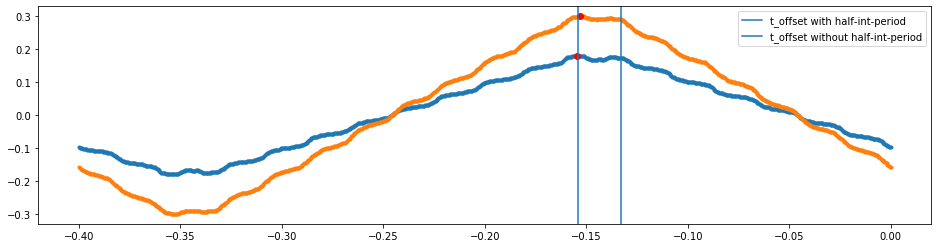

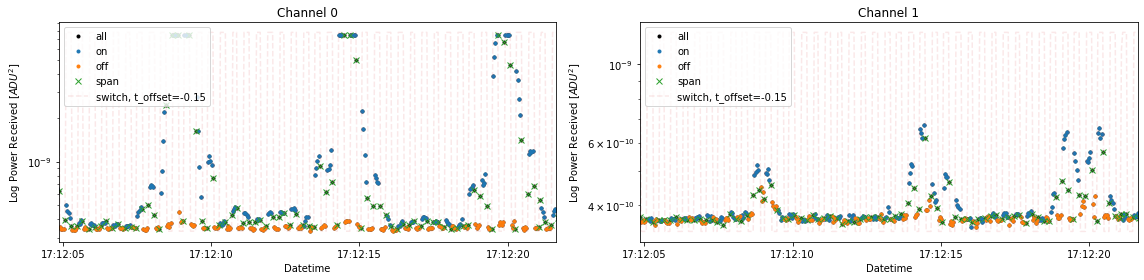

In [98]:
## Find the pulsed source signal: (comment out if source was broadcast continuously)
NF_Grid_1_Concat.Extract_Source_Pulses(Period=0.4e6,\
                                       Dutycycle=0.2e6,\
                                       t_bounds=[2900,3300],\
                                       f_ind=[340],\
                                       half_int_period=+0.021)

In [100]:
NF_Grid_1_Concat.Perform_Background_Subtraction()

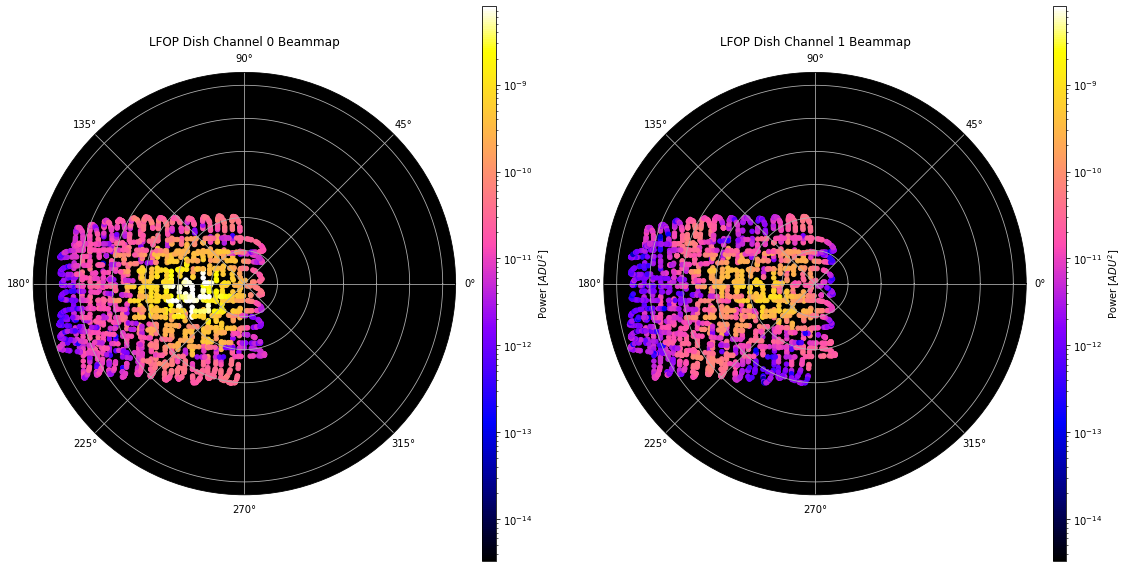

In [137]:
NF_Grid_1_Concat.Plot_Beammap_LC(t_bounds=[700,6600],\
                                 f_bounds=[270,280],\
                                 coord_args="Pol", #"LC","Pol"\
                                 pulse_args="bgsub",# None,"on","off","bg","bgsub"\
                                 cbounds=[],#[1e-11,1e-7],\
                                 dotsize=20)

In [132]:
tlb,tub=[5000,19500] # Full Grid
t_inds=np.intersect1d(NF_Grid_1_Concat.inds_on,NF_Grid_1_Concat.t_index[tlb:tub])
fcutarr=np.arange(256,384)
AFit_f_params=np.zeros((NF_Grid_1_Concat.n_channels,len(fcutarr),4))
GFit_f_params=np.zeros((NF_Grid_1_Concat.n_channels,len(fcutarr),5))
AFit_f_params_B=np.zeros((NF_Grid_1_Concat.n_channels,len(fcutarr),4))
GFit_f_params_B=np.zeros((NF_Grid_1_Concat.n_channels,len(fcutarr),5))
for k in range(NF_Grid_1_Concat.n_channels):
    print(k)
    for j,find in enumerate(fcutarr):
        mbx=NF_Grid_1_Concat.drone_xyz_LC_interp[t_inds,0]
        mby=NF_Grid_1_Concat.drone_xyz_LC_interp[t_inds,1]
        mbz=NF_Grid_1_Concat.drone_xyz_LC_interp[t_inds,2]
        mbV=NF_Grid_1_Concat.V_bgsub[t_inds,find,k]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        x00=Array_Coords[int(k/2),0]
        y00=Array_Coords[int(k/2),1]
        ## airy params:
        rad0=10.0
        ## 2dgauss params:
        xsig0=10.0
        ysig0=10.0
        pA=np.array([amp0,x00,y00,rad0])
        BA=(np.array([0.0,-10.0,-10.0,0.0]),np.array([1e-5,10.0,10.0,100.0]))
        pG=np.array([amp0,x00,xsig0,y00,ysig0])
        BG=(np.array([0.0,-10.0,0.0,-10.0,0.0]),np.array([1e-5,10.0,100.0,10.0,100.0]))
        AFit_f_params[k,j,:]=least_squares(Airy_2d_LC_opt,x0=pA,args=mb_input_data).x
        GFit_f_params[k,j,:]=least_squares(Gauss_2d_LC_opt,x0=pG,args=mb_input_data).x
        AFit_f_params_B[k,j,:]=least_squares(Airy_2d_LC_opt,x0=pA,bounds=BA,args=mb_input_data,method='dogbox').x
        GFit_f_params_B[k,j,:]=least_squares(Gauss_2d_LC_opt,x0=pG,bounds=BG,args=mb_input_data,method='dogbox').x

0


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


1


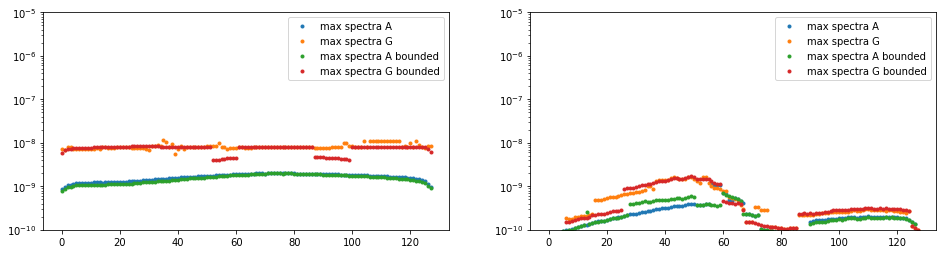

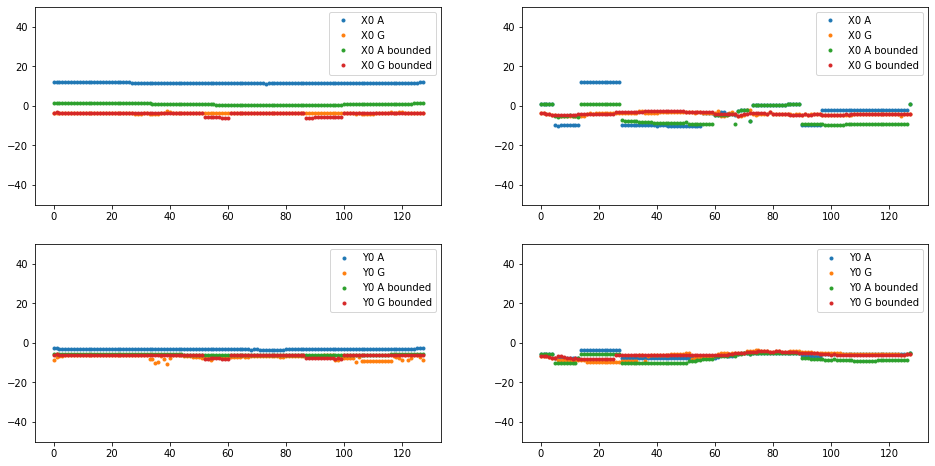

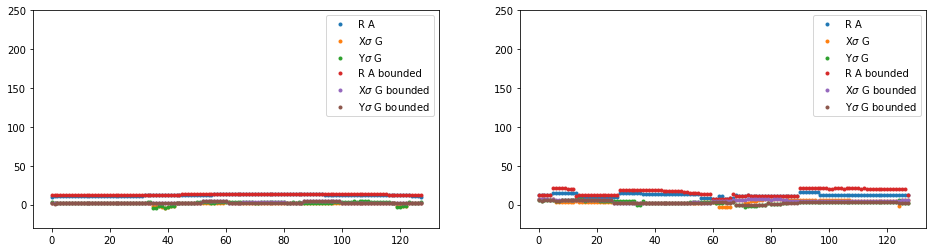

In [133]:
fig1,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,4))
for z,ax in enumerate([ax1,ax2]):
    ax.semilogy(AFit_f_params[z,:,0],'.',label="max spectra A")
    ax.semilogy(GFit_f_params[z,:,0],'.',label="max spectra G")
    ax.semilogy(AFit_f_params_B[z,:,0],'.',label="max spectra A bounded")
    ax.semilogy(GFit_f_params_B[z,:,0],'.',label="max spectra G bounded")
    ax.legend()
    ax.set_ylim(1e-10,1e-5)
    
fig2,[[ax1,ax2],[ax3,ax4]]=subplots(nrows=2,ncols=2,figsize=(16,8))
for z,ax in enumerate([ax1,ax2]):
    ax.plot(AFit_f_params[z,:,1],'.',label="X0 A")
    ax.plot(GFit_f_params[z,:,1],'.',label="X0 G")
    ax.plot(AFit_f_params_B[z,:,1],'.',label="X0 A bounded")
    ax.plot(GFit_f_params_B[z,:,1],'.',label="X0 G bounded")
    ax.legend()
    ax.set_ylim(-50,50)
for z,ax in enumerate([ax3,ax4]):
    ax.plot(AFit_f_params[z,:,2],'.',label="Y0 A")
    ax.plot(GFit_f_params[z,:,3],'.',label="Y0 G")
    ax.plot(AFit_f_params_B[z,:,2],'.',label="Y0 A bounded")
    ax.plot(GFit_f_params_B[z,:,3],'.',label="Y0 G bounded")
    ax.legend()
    ax.set_ylim(-50,50)
    
fig3,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,4))
for z,ax in enumerate([ax1,ax2]):
    ax.plot(AFit_f_params[z,:,3],'.',label="R A")
    ax.plot(GFit_f_params[z,:,2],'.',label="X$\sigma$ G")
    ax.plot(GFit_f_params[z,:,4],'.',label="Y$\sigma$ G")
    ax.plot(AFit_f_params_B[z,:,3],'.',label="R A bounded")
    ax.plot(GFit_f_params_B[z,:,2],'.',label="X$\sigma$ G bounded")
    ax.plot(GFit_f_params_B[z,:,4],'.',label="Y$\sigma$ G bounded")
    ax.legend()
    ax.set_ylim(-30,250)

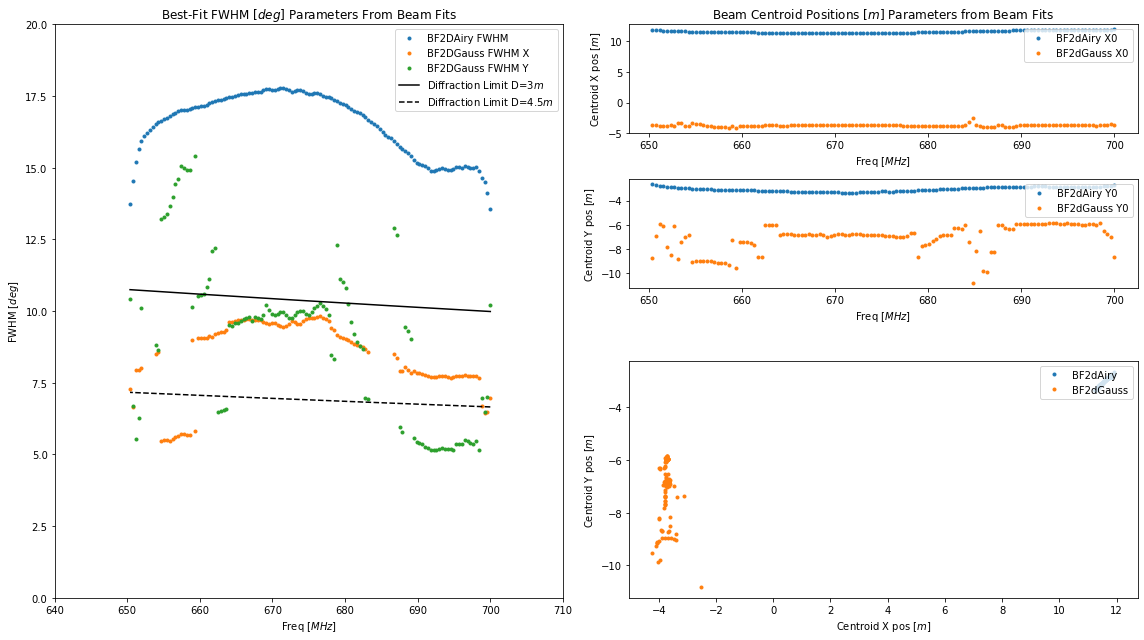

In [136]:
## Use the returned fit parameters to plot FWHM and centroid for these fits:
    # Airy Fit Parameter array:  pA=np.array([amp0,x00,y00,rad0])
    # Gauss Fit Parameter array: pG=np.array([amp0,x00,xsig0,y00,ysig0])

## FWHM in meters (x,y) and degrees in FoV:
Afwhmm_f=2*1.616/3.832*AFit_f_params[:,:,3]
Afwhmd_f=2*180.0/np.pi*np.arctan(1.616/3.832*AFit_f_params[:,:,3]/np.nanmean(mbz))
Gfwhmxm_f=2.355*GFit_f_params[:,:,2]
Gfwhmxd_f=2*180.0/np.pi*np.arctan(0.5*2.355*GFit_f_params[:,:,2]/np.nanmean(mbz))
Gfwhmym_f=2.355*GFit_f_params[:,:,4]
Gfwhmyd_f=2*180.0/np.pi*np.arctan(0.5*2.355*GFit_f_params[:,:,4]/np.nanmean(mbz))

## Centroid Location in meters (x,y) and degrees:
ACent_f=AFit_f_params[:,:,[1,2]]
ACentd_f=np.arctan(AFit_f_params[:,:,[1,2]]/np.nanmean(mbz))
GCent_f=GFit_f_params[:,:,[1,3]]
GCentd_f=np.arctan(GFit_f_params[:,:,[1,3]]/np.nanmean(mbz))

wavelength_m=(3.0*(10.0**8.0))/(FF_Grid_1_Concat.f_arr[fcutarr]*1.0e6)
difflimit=180.0/np.pi*1.22*wavelength_m
   
g=0    
    
fig1=figure(figsize=(16,9))
ax1=fig1.add_subplot(1,2,1)
ax1.plot(NF_Grid_1_Concat.f_arr[fcutarr],Afwhmd_f[g],'.',label="BF2DAiry FWHM")
ax1.plot(NF_Grid_1_Concat.f_arr[fcutarr],Gfwhmxd_f[g],'.',label="BF2DGauss FWHM X")
ax1.plot(NF_Grid_1_Concat.f_arr[fcutarr],Gfwhmyd_f[g],'.',label="BF2DGauss FWHM Y")
ax1.plot(NF_Grid_1_Concat.f_arr[fcutarr],difflimit/3.0,'k-',markersize=0.5,label="Diffraction Limit D=3$m$")
ax1.plot(NF_Grid_1_Concat.f_arr[fcutarr],difflimit/4.5,'k--',markersize=0.5,label="Diffraction Limit D=4.5$m$")
ax1.legend(loc=1)
ax1.set_ylabel("FWHM [$deg$]")
ax1.set_xlabel("Freq [$MHz$]")
ax1.set_title("Best-Fit FWHM [$deg$] Parameters From Beam Fits")


ax2=fig1.add_subplot(4,2,2)
ax2.plot(NF_Grid_1_Concat.f_arr[fcutarr],ACent_f[g,:,0],'.',label='BF2dAiry X0')
ax2.plot(NF_Grid_1_Concat.f_arr[fcutarr],GCent_f[g,:,0],'.',label='BF2dGauss X0')
ax2.set_ylabel("Centroid X pos [$m$]")
ax2.set_xlabel("Freq [$MHz$]")
ax2.set_title("Beam Centroid Positions [$m$] Parameters from Beam Fits")
ax2.legend(loc=1)

ax3=fig1.add_subplot(4,2,4)
ax3.plot(NF_Grid_1_Concat.f_arr[fcutarr],ACent_f[g,:,1],'.',label='BF2dAiry Y0')
ax3.plot(NF_Grid_1_Concat.f_arr[fcutarr],GCent_f[g,:,1],'.',label='BF2dGauss Y0')
ax3.set_ylabel("Centroid Y pos [$m$]")
ax3.set_xlabel("Freq [$MHz$]")
ax3.legend(loc=1)

ax4=fig1.add_subplot(2,2,4)
ax4.plot(ACent_f[g,:,0],ACent_f[g,:,1],'.',label='BF2dAiry')
ax4.plot(GCent_f[g,:,0],GCent_f[g,:,1],'.',label='BF2dGauss')
ax4.set_xlabel("Centroid X pos [$m$]")
ax4.set_ylabel("Centroid Y pos [$m$]")
ax4.legend(loc=1)

ax1.set_xlim(640,710)
ax1.set_ylim(0,20)
#ax4.set_xlim(-1.8,-1.2)
#ax4.set_ylim(-0.5,0.5)
tight_layout()

